<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/SingleStoreDB_%2B_LlamaIndex_Multimodal_Car_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using SingleStore, GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal retrieval system using SingleStore and LlamaIndex with GPT4-V and CLIP.

SingleStoreDB
- Hybrid database for structured + vector data
- Use over LlamaIndex integration

LlamaIndex Multi-Modal Retrieval

- Text embedding index: Generate GPT text embeddings
- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Encoding queries:
* Encode query text for text index using ada
* Encode query text for image index using CLIP

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to undertand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vetor store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriver according to the image reasoning from Step 1

In [ ]:
%pip install git+https://github.com/run-llama/llama_index.git
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U singlestoredb

  Cloning https://github.com/run-llama/llama_index.git to /tmp/pip-req-build-9otqp7ik
  Running command git clone --filter=blob:none --quiet https://github.com/run-llama/llama_index.git /tmp/pip-req-build-9otqp7ik
  Resolved https://github.com/run-llama/llama_index.git to commit 92f82f83f5dc4ea9f236eff066e53df264a8c1f1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jjz92jip
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jjz92jip
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import os

OPENAI_API_TOKEN = "..."
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download our set of images of cars

In [ ]:
!rm -rf ./cars
!rm -rf ./__MACOSX
!wget "https://www.dropbox.com/scl/fi/48f5vfp86ak56tv6647ru/cars.zip?rlkey=8vre28paljf4ovf5269a1w0as&dl=0" -O cars.zip -q
!unzip cars.zip -d .

Archive:  cars.zip
   creating: ./cars/
  inflating: ./__MACOSX/._cars       
  inflating: ./cars/t1.jpg           
  inflating: ./__MACOSX/cars/._t1.jpg  
  inflating: ./cars/t2.jpg           
  inflating: ./__MACOSX/cars/._t2.jpg  
  inflating: ./cars/t3.jpg           
  inflating: ./__MACOSX/cars/._t3.jpg  
  inflating: ./cars/.DS_Store        
  inflating: ./__MACOSX/cars/._.DS_Store  
  inflating: ./cars/t1.txt           
  inflating: ./__MACOSX/cars/._t1.txt  
  inflating: ./cars/t3.txt           
  inflating: ./__MACOSX/cars/._t3.txt  
  inflating: ./cars/t2.txt           
  inflating: ./__MACOSX/cars/._t2.txt  
  inflating: ./cars/o3.txt           
  inflating: ./__MACOSX/cars/._o3.txt  
  inflating: ./cars/v1.txt           
  inflating: ./__MACOSX/cars/._v1.txt  
  inflating: ./cars/o2.txt           
  inflating: ./__MACOSX/cars/._o2.txt  
  inflating: ./cars/v2.txt           
  inflating: ./__MACOSX/cars/._v2.txt  
  inflating: ./cars/v3.txt           
  inflating: ./__MACOSX

### Plot input images

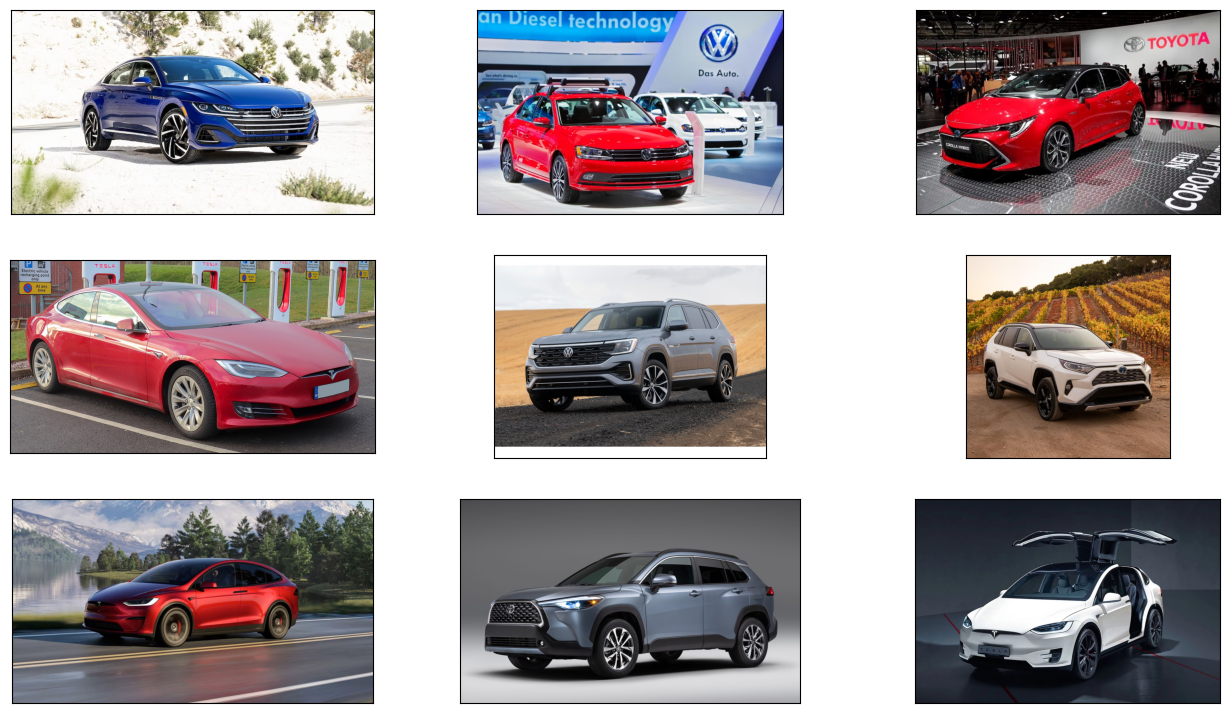

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./cars"):
    image_paths.append(str(os.path.join("./cars", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Using GPT4V to understand those input images

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

image_documents = SimpleDirectoryReader(input_files=["./cars/o2.jpg","./cars/t2.jpg","./cars/v2.jpg"]).load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the car in the image",
    image_documents=image_documents,
)

print(response_1)

The first image shows a white SUV with a modern design, featuring a prominent front grille with the Toyota emblem, angular headlights, and black trim around the wheel arches and lower body, giving it an off-road capable appearance. It's parked in a scenic vineyard setting, suggesting a lifestyle-oriented marketing approach.

The second image is of a red Tesla Model Y, an all-electric compact SUV. It has a sleek, aerodynamic design with a smooth front fascia, lacking a traditional grille, which is characteristic of electric vehicles. The car is in motion, depicted on a road with a lake and mountains in the background, emphasizing its performance and eco-friendly aspects.

The third image showcases a blue Volkswagen Arteon, a luxury sedan with a sporty and elegant design. It features a wide, horizontal grille that merges with the headlights, creating a distinctive front-end look. The car's profile is sleek with a coupe-like roofline, and it's positioned on a desert road, highlighting its

## Build Multi-modal index and vector store to index both text and images

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import SingleStoreVectorStore
from llama_index import SimpleDirectoryReader, StorageContext, ServiceContext

os.environ["SINGLESTOREDB_URL"] = "admin:...@svc-56441794-b2ba-46ad-bc0b-c3d5810a45f4-dml.aws-oregon-3.svc.singlestore.com:3306/multimodal"
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local SingleStore vector store

text_store = SingleStoreVectorStore(
    table_name="t3"
)
image_store = SingleStoreVectorStore(
    table_name="i3"
)

storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./cars").load_data()

print(documents)

index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

[ImageDocument(id_='e1271ec8-f90e-449a-94a9-4a30ccf256ca', embedding=None, metadata={'file_path': 'cars/o1.jpg', 'file_name': 'o1.jpg', 'file_type': 'image/jpeg', 'file_size': 267104, 'creation_date': '2023-12-18', 'last_modified_date': '2023-12-04', 'last_accessed_date': '2023-12-18'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='cb85617450275c777a11cf25e68b3da888852611162472c36516f536c513a277', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='cars/o1.jpg', image_url=None, text_embedding=None), Document(id_='d83b2a03-edb0-43ff-a6cd-2a90ba02c962', embedding=None, metadata={'file_path': 'cars/o1.txt', 'file_name': 'o1.txt', 

## Query text and images from our Multi-Modal Index

### Find the Toyotas

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=1, image_similarity_top_k=1
)
retrieval_results = retriever_engine.retrieve("Show me toyotas")

**Node ID:** c1508240-c9e7-497f-87ed-5fb3d6e08a91<br>**Similarity:** 0.8195465803146362<br>**Text:** Toyota is a Japanese multinational automotive manufacturer headquartered in Toyota City, Aichi, Japan.<br>

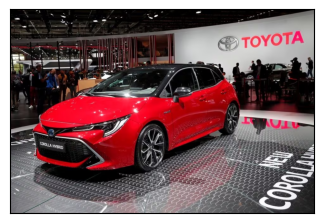

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

## Look for Teslas instead

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=1
)
retrieval_results = retriever_engine.retrieve("Find the Teslas")

**Node ID:** 56cebac1-1515-4baf-a465-865097d99e39<br>**Similarity:** 0.8217452764511108<br>**Text:** Tesla, Inc is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs and manufactures electric vehicles<br>

**Node ID:** c44a5491-8ba6-4d13-ac32-5897af05022e<br>**Similarity:** 0.8192225694656372<br>**Text:** Tesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, via a...<br>

**Node ID:** f1a34ff9-df75-413e-b9f6-e52e4ed76c2f<br>**Similarity:** 0.8025845289230347<br>**Text:** Tesla has been the subject of lawsuits, government scrutiny, and journalistic criticism, stemming from allegations of whistleblower retaliation, worker rights violations, product defects, and Musk'...<br>

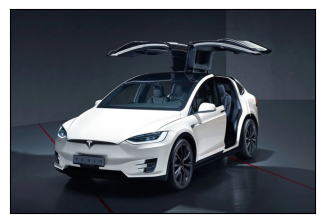

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)